In [1]:
import os
import time
import h5py
import math
import pickle
import numpy as np
import pandas as pd
import cv2
import threading
import queue
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import misc
from sklearn import model_selection, preprocessing, metrics
from sklearn.utils import shuffle
from skimage import transform
from tqdm import tqdm
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.losses import binary_crossentropy
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
from tensorflow.python.client import device_lib

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_PATH = '/kaggle/dev/carvana-image-masking-challenge-data'
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw_data')
TRAIN_PATH = os.path.join(RAW_DATA_PATH, 'train')
TEST_PATH = os.path.join(RAW_DATA_PATH, 'test')
TRAIN_MASKS_PATH = os.path.join(RAW_DATA_PATH, 'train_masks')
TRAIN_MASKS_CSV_PATH = os.path.join(RAW_DATA_PATH, 'train_masks.csv')
SAMPLE_SUBMISSION_PATH = os.path.join(RAW_DATA_PATH, 'sample_submission.csv')
METADATA_PATH = os.path.join(RAW_DATA_PATH, 'metadata.csv')
SUBMISSION_PATH = os.path.join(DATA_PATH, 'submissions')
ASSETS_PATH = os.path.join(DATA_PATH, 'assets')
MODELS_PATH = os.path.join(ASSETS_PATH, 'models')
TENSORBOARD_PATH = os.path.join(ASSETS_PATH, 'tensorboard')

In [3]:
train_masks_df = pd.read_csv(TRAIN_MASKS_CSV_PATH)
print('train_masks_df.shape', train_masks_df.shape)
train_masks_df.head()

train_masks_df.shape (5088, 2)


,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [4]:
# Constants
HEIGHT_ORIG = 1280
WIDTH_ORIG = 1918
CHANNELS_ORIG = 3

HEIGHT = 1024
WIDTH = 1024
CHANNELS = 3
new_shape = (HEIGHT, WIDTH, CHANNELS)
mask_shape = (new_shape[0], new_shape[1], 1)

def get_img_id(img_path):
    return img_path[:15]

img_ids = list(map(get_img_id, list(train_masks_df.img.values)))

def load_image_disk(img_id, folder=TRAIN_PATH):
    return misc.imread(os.path.join(folder, img_id + '.jpg'))

def get_image(img_id):
    return train_imgs[img_id]

# Return mask as 1/0 binary img with single channel
def load_mask_disk(img_id):
    mask = misc.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"), flatten=True)
    mask[mask > 128] = 1
    if len(mask.shape) == 2:
        mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
    return mask

def get_mask(img_id):
    return train_masks[img_id]

# Helper functions to plot car, mask, masked_car
def plot_image(img_id):
    img = misc.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    
def plot_mask(img_id, ax=None):
    mask = misc.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    if ax == None:
        imgplot = plt.imshow(mask)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(mask)
        ax.axis('off')
    
def plot_masked_image(img_id, ax=None):
    img = misc.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    mask = misc.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    mask = mask[:,:,0:3]
    mask[mask == 255] = 1 
    masked_img = img * mask
    if ax == None:
        imgplot = plt.imshow(masked_img)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(masked_img)
        ax.axis('off')
    
def resize_img(img, new_s = new_shape):
    return transform.resize(img, new_s)
#     if len(img.shape) == 3 and img.shape[2] == 1:
#         temp = np.squeeze(y, axis=2) # Remove extra 1 dimension (x, x, 1)
#         temp = misc.imresize(temp, (new_shape[0], new_shape[1])) # Resize img
#         return np.expand_dims(temp, axis=2) # Add extra 1 demsion (x, x, 1)
#     return misc.imresize(img, new_s, interp='bilinear')

In [5]:
# Read training images into memory
train_imgs = {}
for img_path in tqdm(os.listdir(TRAIN_PATH)):
    img_id = get_img_id(img_path)
    train_imgs[img_id] = cv2.resize(load_image_disk(img_id), (new_shape[0], new_shape[1]))

100%|██████████| 5088/5088 [04:01<00:00, 21.07it/s]


In [6]:
# Read training masks into memory
train_masks = {}
for img_path in tqdm(os.listdir(TRAIN_MASKS_PATH)):
    img_id = get_img_id(img_path)
    train_masks[img_id] = np.expand_dims(cv2.resize(load_mask_disk(img_id), (new_shape[0], new_shape[1])), axis=2)

100%|██████████| 5088/5088 [02:52<00:00, 29.43it/s]


In [7]:
def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    return image

def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_REFLECT_101, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(0, 0, 0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(0, 0, 0,))
        if len(mask.shape) == 2:
            mask = np.expand_dims(mask, axis=2)

    return image, mask

def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask

In [8]:
def generate_training_batch(data, batch_size):
    while True:
        X_batch = []
        Y_batch = []
        batch_ids = np.random.choice(data,
                                     size=batch_size,
                                     replace=False)
        for idx, img_id in enumerate(batch_ids):
            x = get_image(img_id)
            y = get_mask(img_id)
            x, y = randomShiftScaleRotate(x, y,
                                          shift_limit=(-0.0625, 0.0625),
                                          scale_limit=(-0.1, 0.1),
                                          rotate_limit=(-0, 0))
#             x = randomHueSaturationValue(x,
#                                hue_shift_limit=(-50, 50),
#                                sat_shift_limit=(-5, 5),
#                                val_shift_limit=(-15, 15))
            X_batch.append(x)
            Y_batch.append(y)
        X = np.asarray(X_batch, dtype=np.float32)
        Y = np.asarray(Y_batch, dtype=np.float32)
        yield X, Y

def generate_validation_batch(data, batch_size):
    while True:
        X_batch = []
        Y_batch = []
        batch_ids = np.random.choice(data,
                                     size=batch_size,
                                     replace=False)
        for idx, img_id in enumerate(batch_ids):
            x = get_image(img_id)
            y = get_mask(img_id)
            X_batch.append(x)
            Y_batch.append(y)
        X = np.asarray(X_batch, dtype=np.float32)
        Y = np.asarray(Y_batch, dtype=np.float32)
        yield X, Y

def generate_validation_data_seq(data):
    idx = 0
    while True:
        img_id = data[idx]
        X = get_image(img_id)
        Y = get_mask(img_id)
        yield img_id, X, Y
        idx  += 1
        if idx >= len(data):
            break

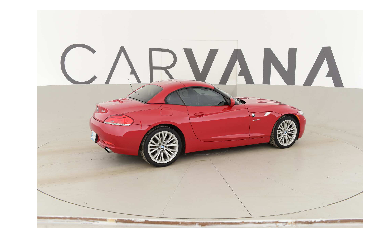

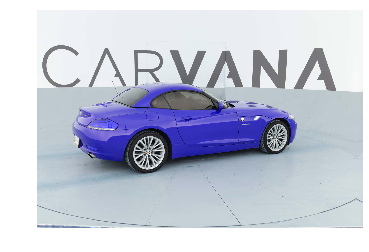

In [9]:
# Visualize impact of random shift scale rotate
random_idx = np.random.randint(len(train_imgs.keys()))
random_img_id = list(train_imgs.keys())[random_idx]
plot_image(random_img_id)
mask = get_mask(img_id)
temp_img = cv2.imread(os.path.join(TRAIN_PATH, '{}.jpg'.format(random_img_id)))
temp_img, _ = randomShiftScaleRotate(temp_img, mask,
                              shift_limit=(-0.0625, 0.0625),
                              scale_limit=(-0.1, 0.1),
                              rotate_limit=(-0, 0))
plt.imshow(temp_img)
plt.axis('off')
plt.show()

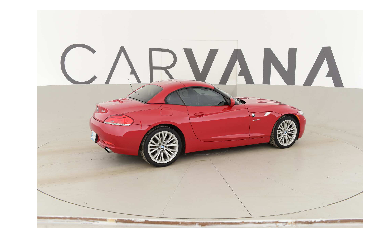

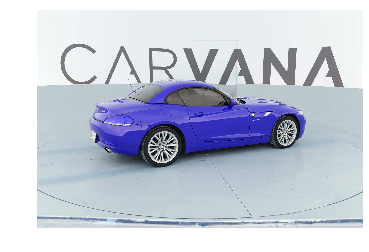

In [10]:
# Visualize impact of random hue saturation
# random_idx = np.random.randint(len(train_imgs.keys()))
# random_img_id = list(train_imgs.keys())[random_idx]
plot_image(random_img_id)
temp_img = cv2.imread(os.path.join(TRAIN_PATH, '{}.jpg'.format(random_img_id)))
temp_img = randomHueSaturationValue(temp_img,
                               hue_shift_limit=(-50, 50),
                               sat_shift_limit=(-5, 5),
                               val_shift_limit=(-15, 15))
plt.imshow(temp_img)
plt.axis('off')
plt.show()

In [11]:
def down(filters, input_):
    down_ = Conv2D(filters, (3, 3), padding='same')(input_)
    down_ = BatchNormalization()(down_)
    down_ = Activation('relu')(down_)
    down_ = Conv2D(filters, (3, 3), padding='same')(down_)
    down_ = BatchNormalization()(down_)
    down_res = Activation('relu')(down_)
    down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_)
    return down_pool, down_res

def up(filters, input_, down_):
    up_ = UpSampling2D((2, 2))(input_)
    up_ = concatenate([down_, up_], axis=3)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization()(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization()(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization()(up_)
    up_ = Activation('relu')(up_)
    return up_

In [12]:
def get_unet_1024(input_shape=(HEIGHT, WIDTH, CHANNELS), num_classes=1):
    inputs = Input(shape=input_shape)

    down0b, down0b_res = down(8, inputs)
    down0a, down0a_res = down(16, down0b)
    down0, down0_res = down(32, down0a)
    down1, down1_res = down(64, down0)
    down2, down2_res = down(128, down1)
    down3, down3_res = down(256, down2)
    down4, down4_res = down(512, down3)
    down5, down5_res = down(1024, down4)
    
    center = Conv2D(2048, (3, 3), padding='same')(down5)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(2048, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)

    up5 = up(1024, center, down5_res)
    up4 = up(512, up5, down4_res)
    up3 = up(256, up4, down3_res)
    up2 = up(128, up3, down2_res)
    up1 = up(64, up2, down1_res)
    up0 = up(32, up1, down0_res)
    up0a = up(16, up0, down0a_res)
    up0b = up(8, up0a, down0b_res)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid', name='final_layer')(up0b)

    model = Model(inputs=inputs, outputs=classify)

    return model

In [13]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_v2(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_pred_f = K.greater_equal(y_pred_f, 0.5)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

In [16]:
# def weighted_bce_loss(y_true, y_pred, weight):
#     # avoiding overflow
#     epsilon = 1e-7
#     y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
#     logit_y_pred = K.log(y_pred / (1. - y_pred))
    
#     # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
#     loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
#     (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
#     return K.sum(loss) / K.sum(weight)

# def weighted_dice_coef(y_true, y_pred, weight):
#     smooth = 1.
#     w, m1, m2 = weight * weight, y_true, y_pred
#     intersection = (m1 * m2)
#     score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
#     return score

# def weighted_dice_loss(y_true, y_pred, weight):
#     return 1. - weighted_dice_coef(y_true, y_pred, weight)

# def weighted_bce_dice_loss(y_true, y_pred):
#     y_true = K.cast(y_true, 'float32')
#     y_pred = K.cast(y_pred, 'float32')
#     # if we want to get same size of output, kernel size must be odd number
#     averaged_mask = K.pool2d(
#             y_true, pool_size=(41, 41), strides=(1, 1), padding='same', pool_mode='avg')
#     border = K.cast(K.greater(averaged_mask, 0.01), 'float32') * K.cast(K.less(averaged_mask, 0.99), 'float32')
#     weight = K.ones_like(averaged_mask)
#     w0 = K.sum(weight)
#     weight += border * 2
#     w1 = K.sum(weight)
#     weight *= (w0 / w1)
#     loss = weighted_bce_loss(y_true, y_pred, weight) + \
#     weighted_dice_loss(y_true, y_pred, weight)
#     return loss

In [14]:
BATCH_SIZE = 4

In [16]:
ts = str(int(time.time()))
model_name = 'malhot'
num_epochs = 30
steps_per_epoch = 1018
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}-ts={}'.format(model_name,
                                                                          BATCH_SIZE,
                                                                          num_epochs,
                                                                          steps_per_epoch,
                                                                          ts)
tensorboard_loc = os.path.join(TENSORBOARD_PATH, run_name)
checkpoint_loc = os.path.join(MODELS_PATH, 'model-{}-weights.h5'.format(ts))

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=2, 
                              verbose=1, 
                              min_delta = 0.0001,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(checkpoint_loc,
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = True)

tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0, write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, earlyStopping, tensorboard]

model = get_unet_1024()
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=0.0001), metrics=[dice_coef])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1024, 1024, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 1024, 1024, 8) 224         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 1024, 1024, 8) 32          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 1024, 1024, 8) 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [20]:
train_ids, validation_ids = model_selection.train_test_split(img_ids, random_state=42, test_size=0.20)
train_generator = generate_training_batch(train_ids, BATCH_SIZE)
valid_generator = generate_validation_batch(validation_ids, BATCH_SIZE)
VALIDATION_STEPS = int(len(validation_ids) / BATCH_SIZE)

In [19]:
model = get_unet_1024()
model.load_weights(os.path.join(MODELS_PATH, 'model-1504991209-weights.h5'))
model.compile(loss=bce_dice_loss, optimizer=Adam(1e-5), metrics=[dice_coef])

In [ ]:
print('Starting run {}'.format(run_name))
history = model.fit_generator(
        train_generator, 
        steps_per_epoch = steps_per_epoch, 
        epochs = num_epochs,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = VALIDATION_STEPS)

model_path = os.path.join(MODELS_PATH, 'model-{}.h5'.format(ts))
history_path = os.path.join(MODELS_PATH, 'model-{}.history'.format(ts))
model.save(model_path)
pickle.dump(history.history, open(history_path, "wb"))
print('Saved model at {}'.format(model_path))
print('Saved model history at {}'.format(history_path))

Starting run model=malhot-batch_size=4-num_epoch=30-steps_per_epoch=1018-ts=1505023046
Epoch 1/30
 910/1018 [=========================>....] - ETA: 307s - loss: 0.0111 - dice_coef: 0.9943

In [13]:
model = get_unet_1024()
model.load_weights(os.path.join(MODELS_PATH, 'model-1504991209-weights.h5'))
model.compile(loss=weighted_bce_dice_loss, optimizer=Adam(1e-4), metrics=[dice_coef])

In [22]:
model.evaluate_generator(valid_generator, VALIDATION_STEPS)

[0.024601157959990613, 0.99411736769000381]

### Error analysis on validation set

In [ ]:
validation_dices = []
for img_id, X, Y in generate_validation_data_seq(validation_ids):
    error = model.evaluate(np.expand_dims(X, axis=0), np.expand_dims(Y, axis=0), verbose=0)
    validation_dices.append((img_id, error[0], error[1]))

val_eval_df = pd.DataFrame.from_records(validation_dices, columns=['img_id', 'val_loss', 'dice_coef'])
val_eval_df.head()

In [21]:
val_eval_df.to_csv(os.path.join(ASSETS_PATH, 'val_eval_df-1504835402.csv'), index=False)

NameError: name 'val_eval_df' is not defined

In [22]:
val_eval_df = pd.read_csv(os.path.join(ASSETS_PATH, 'val_eval_df-1504835402.csv'))

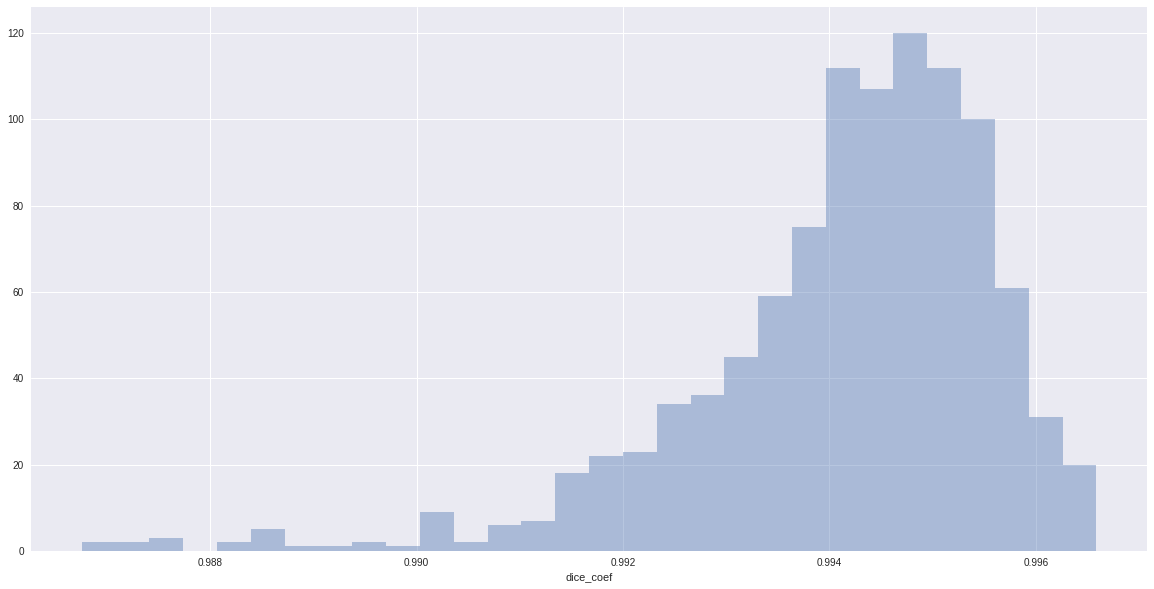

In [23]:
plt.figure(figsize=(20,10))
sns.distplot(val_eval_df['dice_coef'], kde=False)

In [24]:
np.median(val_eval_df['dice_coef'])

0.99443277716636658

In [25]:
np.mean(val_eval_df['dice_coef'])

0.99413707003377982

In [84]:
np.std(val_eval_df['dice_coef'])

0.0014835427593331994

In [27]:
def get_outliers(data, col, m=2):
    return data[abs(data[col] - np.mean(data[col])) > m * np.std(data[col])]

In [28]:
outlier_df = get_outliers(val_eval_df, 'dice_coef')
outlier_df = outlier_df.sort_values('dice_coef')
outlier_df

,img_id,val_loss,dice_coef
831,2cb06c1f5bb1_02,0.079212,0.986757
716,f3eee6348205_09,0.061514,0.986847
581,4a4364d7fc6d_11,0.077020,0.987113
504,99639c826ea5_13,0.079408,0.987229
387,293a0fa72e5b_01,0.062620,0.987568
837,26ccab021981_01,0.073674,0.987599
1003,e8f607100c1f_05,0.055114,0.987700
701,0ed6904e1004_10,0.066995,0.988121
261,bf9932f7aca8_10,0.050668,0.988273
128,bf9932f7aca8_04,0.056688,0.988474


2cb06c1f5bb1_02


/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


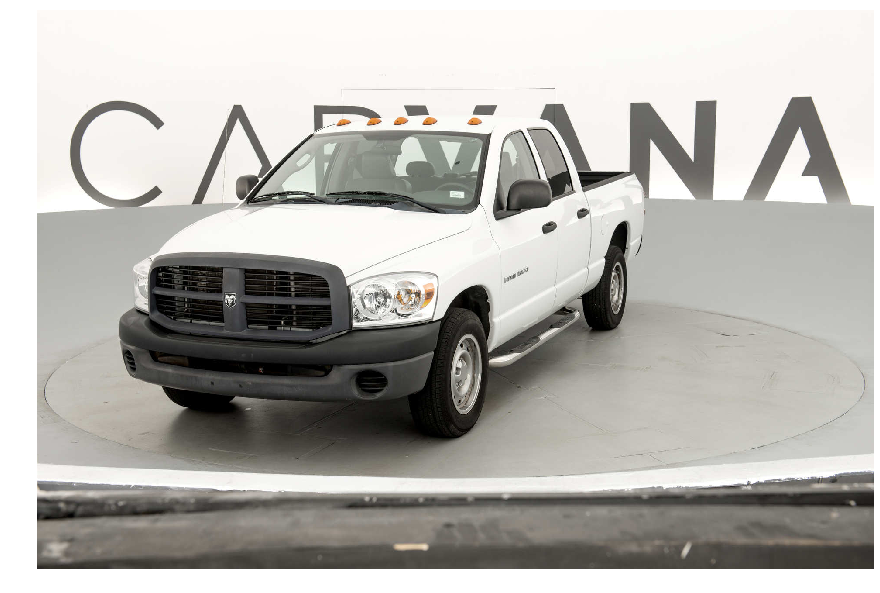

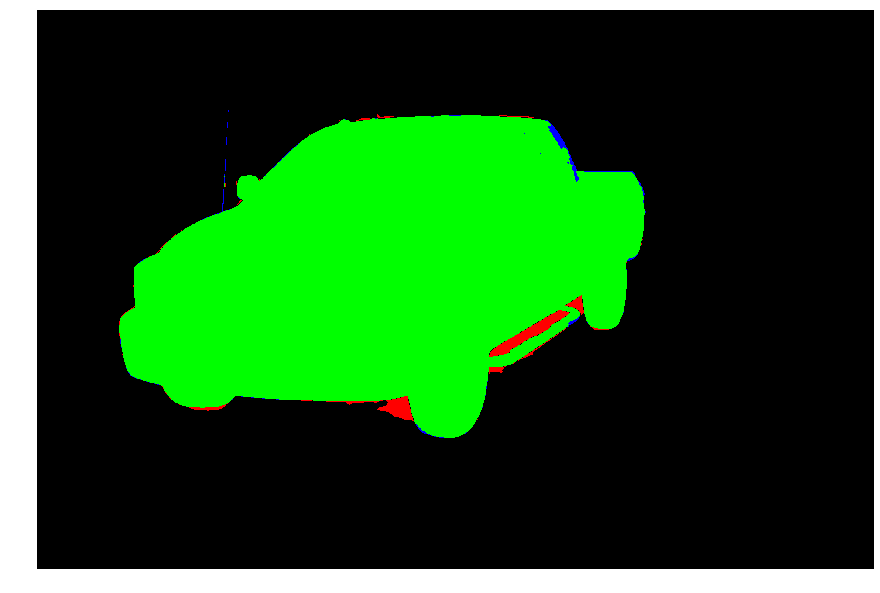

In [189]:
for img_id in outlier_df.img_id.tolist():
    print(img_id)
    test_img = get_image(img_id)

    # Plot original image
    actual_img = load_image_disk(img_id)
    plt.figure(figsize=(15, 15))
    plt.imshow(actual_img)
    plt.axis('off')
    
    # Predict mask
    pred_mask = model.predict(np.expand_dims(test_img, axis=0))
    
    # Plot predicted mask
    pred_mask = np.squeeze(pred_mask)    
    pred_mask = resize_img(pred_mask, (HEIGHT_ORIG, WIDTH_ORIG))
    pred_mask[pred_mask <= 0.5] = 0
    pred_mask[pred_mask > 0.5] = 1

    # Plot ground truth mask
    mask = load_mask_disk(img_id)
    mask = np.squeeze(mask)
    mask = resize_img(mask, (HEIGHT_ORIG, WIDTH_ORIG))
        
    # Plot intersection (true_positives) of two masks
    true_positives = pred_mask * mask
    
    # Plot false positives (pred_mask == 1 && mask == 0)
    false_positives = np.zeros_like(mask)
    false_positives[(pred_mask == 1) & (mask == 0)] = 1
    
    # Plot false negatives (pred_mask == 0 && mask == 1)
    false_negatives = np.zeros_like(mask)
    false_negatives[(pred_mask == 0) & (mask == 1)] = 1

    # Plot true negatives (pred_mask == 0 && mask == 0)
    true_negatives = np.zeros_like(mask)
    true_negatives[(pred_mask == 0) & (mask == 0)] = 1
    
    # Plot merged mask 
    # Legend: 
    #   Red: false positives 
    #   Green: true positives
    #   Blue: false negatives
    #   Black: true negatives
    #   White: background (unclassified pixels) - this should never be visible
    rgb_merged_mask = np.zeros((HEIGHT_ORIG, WIDTH_ORIG, CHANNELS_ORIG))
    rgb_merged_mask = 255 # White
    rgb_true_positives = gray2rgb(true_positives)
    rgb_false_positives = gray2rgb(false_positives)
    rgb_false_negatives = gray2rgb(false_negatives)
    rgb_true_negatives = gray2rgb(true_negatives)

    rgb_merged_mask = rgb_true_positives + rgb_false_positives + rgb_false_negatives + rgb_true_negatives
    rgb_merged_mask[true_positives == 1] = [0, 255, 0] # Green
    rgb_merged_mask[false_positives == 1] = [255, 0, 0] # Red
    rgb_merged_mask[false_negatives == 1] = [0, 0, 255] # Blue
    rgb_merged_mask[true_negatives == 1] = [0, 0, 0] # Black
    
    plt.figure(figsize=(15, 15))
    plt.imshow(rgb_merged_mask)
    plt.axis('off')

In [30]:
# Helper methods
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def gray2rgb(img):
    img = np.squeeze(img)
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = img
    ret[:, :, 1] = img
    ret[:, :, 2] = img
    return ret

def load_imgs(img_ids, folder=TRAIN_PATH):
    imgs = []
    for img_id in img_ids:
        img = misc.imread(os.path.join(folder, img_id + ".jpg"))
        imgs.append(img)
    return np.asarray(imgs)

def resize_imgs(imgs, factor=0.1):
    resized_imgs = []
    for img in imgs:
        resized_img = rescale(img, factor)
        resized_imgs.append(resized_img)
    return np.asarray(resized_imgs)

def rescale_and_clean_masks(masks):
    clean_masks = np.zeros((masks.shape[0], HEIGHT_ORIG, WIDTH_ORIG, 1), dtype=np.uint8)
    for i in range(masks.shape[0]):        
        mask = resize(masks[i], (HEIGHT_ORIG, WIDTH_ORIG, 1))
        mask[mask <= 0.5] = 0
        mask[mask > 0.5] = 1
        clean_masks[i] = mask
    return clean_masks

def rle_masks(masks):  
    rles = []
    for i in range(masks.shape[0]):
        rles.append(rle_to_string(rle_encode(masks[i])))
    return rles

In [167]:
# model = unet()
# model.load_weights('/kaggle/dev/ashish/carvana-image-masking-challenge/notebooks/model-1503722301-weights.h5')

(1280, 1918, 3)


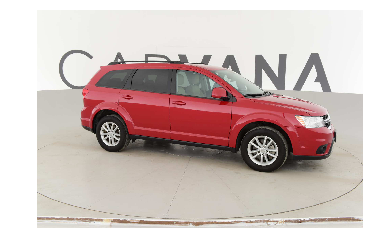

/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(2560, 1918)


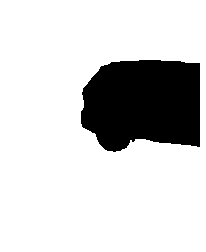

ValueError: operands could not be broadcast together with shapes (1280,1918,3) (2560,1918,3) 

In [188]:
# Visualize performance on first 5 test imgs
for img_path in os.listdir(TEST_PATH)[0:5]:
    img_id = get_img_id(img_path)
    test_img = load_image(img_id, TEST_PATH)
    print(test_img.shape)
    plt.imshow(test_img)
    plt.axis('off')
    plt.show()
    
    resized_test_img = resize_img(test_img)

    pred_mask = model.predict(np.expand_dims(resized_test_img, axis=0))
    pred_mask = pred_mask.reshape(pred_mask.shape[1], pred_mask.shape[2])
    pred_mask = rescale(pred_mask, 10)
    pred_mask = pred_mask[:, 0:1918]
    
    pred_mask[pred_mask <= 0.5] = 0
    pred_mask[pred_mask > 0.5] = 1
    
# #     pred_mask_rle = rle_to_string(rle_encode(pred_mask))
# #     result.append((img_path, pred_mask_rle))
    
    print(pred_mask.shape)
    plt.imshow(pred_mask)
    plt.axis('off')
    plt.show()
    
    rgb_pred_mask = gray2rgb(pred_mask)
    masked_img = test_img * rgb_pred_mask
    print(masked_img.shape)
    imgplot = plt.imshow(masked_img)
    plt.axis('off')
    plt.show()

In [71]:
test_img_paths = os.listdir(TEST_PATH)
test_img_ids = list(map(get_img_id, test_img_paths))

TEST_BATCH_SIZE = 16
NUM_BATCHES = int(math.ceil(len(test_img_ids) / TEST_BATCH_SIZE))

result = []
for batch in tqdm(range(NUM_BATCHES)):
    start = batch * TEST_BATCH_SIZE
    end = start + TEST_BATCH_SIZE
    end = len(test_img_ids) if end > len(test_img_ids) else end
    test_imgs = load_imgs(test_img_ids[start:end], TEST_PATH)
    resized_test_imgs = resize_imgs(test_imgs)
    pred_masks = model.predict(resized_test_imgs)
    clean_masks = rescale_and_clean_masks(pred_masks)
    rles = rle_masks(clean_masks)
    result.extend(zip(test_img_paths[start:end], rles))

sub_ts = str(int(time.time()))
submission_df = pd.DataFrame.from_records(result, columns=['img', 'rle_mask'])
sub_file_path = os.path.join(SUBMISSION_PATH, 'malhot-submission-{}.csv'.format(sub_ts))
submission_df.to_csv(sub_file_path, index=False)
print('Generated submission {}'.format(sub_file_path))

  0%|          | 0/6254 [00:00<?, ?it/s]/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 6254/6254 [8:51:47<00:00,  5.11s/it]  


Generated submission /kaggle/dev/carvana-image-masking-challenge-data/submissions/malhot-submission-1503802126.csv


In [73]:
# Reduce random dots in output masks
# new_result = []
# for idx in tqdm(range(len(result))):
#     img_path = result[idx][0]
#     mask = result[idx][1]
#     rle_decoded_mask = rle_decode(mask, (HEIGHT_ORIG, WIDTH_ORIG, 1))
#     limg = measure.label(rle_decoded_mask)
#     props = measure.regionprops(limg)
#     props = sorted(props, key=lambda p: -p.area)
#     # Erase all except the biggest blob
#     rle_decoded_mask &= (limg == props[0].label)
#     new_result.append((img_path, rle_to_string(rle_encode(rle_decoded_mask))))

In [74]:
# sub_ts = str(int(time.time()))
# submission_df = pd.DataFrame.from_records(new_result, columns=['img', 'rle_mask'])
# sub_file_path = os.path.join(SUBMISSION_PATH, 'malhot-submission-{}.csv'.format(sub_ts))
# submission_df.to_csv(sub_file_path, index=False)
# print('Generated submission {}'.format(sub_file_path))

In [15]:
# Multi GPU inference code

sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION_PATH)
input_size = HEIGHT
batch_size = 4
orig_width = WIDTH_ORIG
orig_height = HEIGHT_ORIG
threshold = 0.5

gpus = [x.name for x in device_lib.list_local_devices() if x.name[:4] == '/gpu']

df_test = pd.read_csv(SAMPLE_SUBMISSION_PATH)
ids_test = df_test['img'].map(lambda s: s.split('.')[0])

names = []
rles = []
q_size = 10

for id in ids_test:
    names.append('{}.jpg'.format(id))

# https://www.kaggle.com/stainsby/fast-tested-rle
def run_length_encode(mask):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle

def create_model(gpu):
    with tf.device(gpu):
        model = get_unet_1024()
    model.load_weights(os.path.join(MODELS_PATH, 'model-1504147454-weights.h5'))
    return model

def data_loader(q, ):
    for start in tqdm(range(0, len(ids_test), batch_size)):
        x_batch = []
        end = min(start + batch_size, len(ids_test))
        ids_test_batch = ids_test[start:end]
        for id in ids_test_batch.values:
            img = load_image(id, TEST_PATH)
            if input_size is not None:
                img = cv2.resize(img, (input_size, input_size), interpolation=cv2.INTER_LINEAR)
            x_batch.append(img)
        x_batch = np.array(x_batch, np.float32) / 255
        q.put((ids_test_batch, x_batch))
    for g in gpus:
        q.put((None, None))

def predictor(q, gpu):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    with sess.as_default():
        model = create_model(gpu)
        while True:
            ids, x_batch = q.get()
            if ids is None:
                break
            preds = model.predict_on_batch(x_batch)
            preds = np.squeeze(preds, axis=3)
            for i,pred in enumerate(preds):
                if input_size is not None:
                    prob = cv2.resize(pred, (orig_width, orig_height), interpolation=cv2.INTER_LINEAR)
                else:
                    prob = pred
                mask = prob > threshold
                rle = run_length_encode(mask)
                id = ids.iloc[i]
                rles.append((id, rle))


print('Predicting on {} samples with batch_size = {}...'.format(len(ids_test), batch_size))
q = queue.Queue(maxsize=q_size)
threads = []
threads.append(threading.Thread(target=data_loader, name='DataLoader', args=(q,)))
threads[0].start()
for gpu in gpus:
    print("Starting predictor at device " + gpu)

    t = threading.Thread(target=predictor, name='Predictor', args=(q, gpu))
    threads.append(t)
    t.start()

# Wait for all threads to finish
for t in threads:
    t.join()

sub_ts = str(int(time.time()))
submission_df = pd.DataFrame(rles, columns=['img', 'rle_mask'])
submission_df['img'] += '.jpg'
sub_file_path = os.path.join(SUBMISSION_PATH, 'malhot-submission-{}.csv.gz'.format(sub_ts))
submission_df.to_csv(sub_file_path, index=False, compression='gzip')
print('Generated submission {}'.format(sub_file_path))


  0%|          | 0/25016 [00:00<?, ?it/s]

Predicting on 100064 samples with batch_size = 4...
Starting predictor at device /gpu:0
Starting predictor at device /gpu:1



  1%|          | 288/25016 [02:14<3:06:33,  2.21it/s]


  2%|▏         | 574/25016 [04:20<3:37:58,  1.87it/s]


  3%|▎         | 860/25016 [06:24<2:44:53,  2.44it/s]


  5%|▍         | 1144/25016 [08:28<2:51:42,  2.32it/s]


  6%|▌         | 1426/25016 [10:32<3:02:20,  2.16it/s]


  7%|▋         | 1708/25016 [12:36<3:01:56,  2.14it/s]


  8%|▊         | 1990/25016 [14:40<2:37:25,  2.44it/s]


  9%|▉         | 2272/25016 [16:45<2:49:55,  2.23it/s]


 10%|█         | 2554/25016 [18:50<2:56:29,  2.12it/s]


 11%|█▏        | 2836/25016 [20:55<2:48:08,  2.20it/s]


 12%|█▏        | 3118/25016 [22:59<2:36:47,  2.33it/s]


 14%|█▎        | 3400/25016 [25:02<2:27:32,  2.44it/s]


 15%|█▍        | 3682/25016 [27:06<2:41:02,  2.21it/s]


 16%|█▌        | 3964/25016 [29:11<2:29:51,  2.34it/s]


 17%|█▋        | 4246/25016 [31:14<2:43:21,  2.12it/s]


 18%|█▊        | 4528/25016 [33:17<2:10:48,  2.61it/s]


 19%|█▉        | 4810/25016 [35:20<2:08:27,  2.62it/s]


 20%|██        | 5092/25016 [37:24<2:17:37,  2.41it/s]


 21%|██▏       | 5374/25016 [39:28<2:24:32,  2.26it/s]


 23%|██▎       | 5656/25016 [41:31<2:50:06,  1.90it/s]


 24%|██▎       | 5938/25016 [43:34<2:16:10,  2.33it/s]


 25%|██▍       | 6220/25016 [45:35<2:12:13,  2.37it/s]


 26%|██▌       | 6502/25016 [47:38<2:13:51,  2.31it/s]


 27%|██▋       | 6784/25016 [49:42<1:55:02,  2.64it/s]


 28%|██▊       | 7066/25016 [51:44<2:22:33,  2.10it/s]


 29%|██▉       | 7348/25016 [53:45<2:05:53,  2.34it/s]


 31%|███       | 7630/25016 [55:48<2:15:23,  2.14it/s]


 32%|███▏      | 7912/25016 [57:51<2:27:00,  1.94it/s]


 33%|███▎      | 8194/25016 [59:55<1:56:13,  2.41it/s]


 34%|███▍      | 8466/25016 [1:01:54<1:40:53,  2.73it/s]


 35%|███▍      | 8738/25016 [1:03:53<1:48:39,  2.50it/s]


 36%|███▌      | 9010/25016 [1:05:51<1:58:02,  2.26it/s]


 37%|███▋      | 9282/25016 [1:07:49<1:50:49,  2.37it/s]


 38%|███▊      | 9554/25016 [1:09:46<1:41:59,  2.53it/s]


 39%|███▉      | 9826/25016 [1:11:45<2:00:48,  2.10it/s]


 40%|████      | 10096/25016 [1:13:44<1:55:36,  2.15it/s]


 41%|████▏     | 10364/25016 [1:15:41<1:43:17,  2.36it/s]


 43%|████▎     | 10632/25016 [1:17:37<1:38:26,  2.44it/s]


 44%|████▎     | 10900/25016 [1:19:34<2:10:03,  1.81it/s]


 45%|████▍     | 11168/25016 [1:21:30<1:39:51,  2.31it/s]


 46%|████▌     | 11436/25016 [1:23:27<1:36:36,  2.34it/s]


 47%|████▋     | 11704/25016 [1:25:24<1:37:28,  2.28it/s]


 48%|████▊     | 11972/25016 [1:27:21<1:38:21,  2.21it/s]


 49%|████▉     | 12240/25016 [1:29:18<1:30:51,  2.34it/s]


 50%|█████     | 12508/25016 [1:31:14<1:51:49,  1.86it/s]


 51%|█████     | 12776/25016 [1:33:10<1:30:47,  2.25it/s]


 52%|█████▏    | 13044/25016 [1:35:08<1:25:29,  2.33it/s]


 53%|█████▎    | 13312/25016 [1:37:04<1:16:57,  2.53it/s]


 54%|█████▍    | 13580/25016 [1:39:03<1:20:32,  2.37it/s]


 55%|█████▌    | 13848/25016 [1:41:00<1:29:36,  2.08it/s]


 56%|█████▋    | 14116/25016 [1:42:57<1:12:17,  2.51it/s]


 57%|█████▋    | 14384/25016 [1:44:53<1:07:30,  2.62it/s]


 59%|█████▊    | 14652/25016 [1:46:50<1:05:49,  2.62it/s]


 60%|█████▉    | 14920/25016 [1:48:47<1:03:50,  2.64it/s]


 61%|██████    | 15188/25016 [1:50:44<1:13:37,  2.22it/s]


 62%|██████▏   | 15456/25016 [1:52:42<1:12:28,  2.20it/s]


 63%|██████▎   | 15724/25016 [1:54:38<1:03:57,  2.42it/s]


 64%|██████▍   | 15992/25016 [1:56:34<58:37,  2.57it/s]  


 65%|██████▍   | 16260/25016 [1:58:31<56:25,  2.59it/s]  


 66%|██████▌   | 16528/25016 [2:00:28<1:03:45,  2.22it/s]


 67%|██████▋   | 16798/25016 [2:02:24<59:13,  2.31it/s]  


 68%|██████▊   | 17068/25016 [2:04:22<57:31,  2.30it/s]


 69%|██████▉   | 17341/25016 [2:06:20<1:01:57,  2.06it/s]


 70%|███████   | 17615/25016 [2:08:21<55:19,  2.23it/s]  


 72%|███████▏  | 17889/25016 [2:10:21<51:00,  2.33it/s]


 73%|███████▎  | 18165/25016 [2:12:20<44:26,  2.57it/s]


 74%|███████▎  | 18441/25016 [2:14:19<45:59,  2.38it/s]


 75%|███████▍  | 18717/25016 [2:16:20<43:36,  2.41it/s]


 76%|███████▌  | 18993/25016 [2:18:20<37:05,  2.71it/s]


 77%|███████▋  | 19269/25016 [2:20:21<40:20,  2.37it/s]


 78%|███████▊  | 19545/25016 [2:22:21<37:50,  2.41it/s]


 79%|███████▉  | 19821/25016 [2:24:20<41:07,  2.11it/s]


 80%|████████  | 20097/25016 [2:26:20<37:36,  2.18it/s]


 81%|████████▏ | 20373/25016 [2:28:19<34:19,  2.25it/s]


 83%|████████▎ | 20649/25016 [2:30:19<31:17,  2.33it/s]


 84%|████████▎ | 20925/25016 [2:32:19<28:56,  2.36it/s]


 85%|████████▍ | 21201/25016 [2:34:19<29:53,  2.13it/s]


 86%|████████▌ | 21477/25016 [2:36:20<25:30,  2.31it/s]


 87%|████████▋ | 21753/25016 [2:38:22<21:58,  2.47it/s]


 88%|████████▊ | 22029/25016 [2:40:23<21:22,  2.33it/s]


 89%|████████▉ | 22305/25016 [2:42:22<22:12,  2.03it/s]


 90%|█████████ | 22581/25016 [2:44:23<17:49,  2.28it/s]


 91%|█████████▏| 22857/25016 [2:46:23<14:15,  2.52it/s]


 92%|█████████▏| 23133/25016 [2:48:22<12:02,  2.61it/s]


 94%|█████████▎| 23409/25016 [2:50:23<11:26,  2.34it/s]


 95%|█████████▍| 23685/25016 [2:52:23<08:13,  2.69it/s]


 96%|█████████▌| 23961/25016 [2:54:24<07:30,  2.34it/s]


 97%|█████████▋| 24237/25016 [2:56:24<04:51,  2.67it/s]


 98%|█████████▊| 24513/25016 [2:58:24<03:46,  2.22it/s]


 99%|█████████▉| 24789/25016 [3:00:27<02:02,  1.85it/s]


100%|██████████| 25016/25016 [3:02:06<00:00,  2.03it/s]


Generated submission /kaggle/dev/carvana-image-masking-challenge-data/submissions/malhot-submission-1504232660.csv.gz
